# New feature evaluation experiment

Company helps its customers grow their apps’ user base with powerful machine-learning models designed to identify users most likely to install & engage with the customers’ apps. Company serves ads to these identified users promoting their customers’ apps. The end goal is for these users to install the advertised app after seeing the ad. 

Machine learning engineers recently developed a new feature that can potentially increase the number of view-through install conversions. 

Before putting this model into production, Company performed a 50/50 AB test to verify if this new feature truly improves performance. The user traffic is randomly assigned to either the control or the experiment group. In this project I will analyze the AB test results and recommend whether or not Company should launch this feature. 


## Glossary 

* Spend: the amount of money spent serving ads to users. 
* Impressions: the number of times an ad is shown to users.
* Installs: the number of users who download the advertised app onto their mobile devices, installs are further identified as either click-through installs or view-through installs where:

    - click-through install (aka CT install) = an install that was acquired after the user saw an ad and clicked on the ad. 

    - view-through install (aka VT install) = an install that was acquired after the user saw an ad (did not click on the ad).

Note that some customers are more sensitive than others to increases in view-through installs because these customers believe click-through installs have a higher signal of intent to engage with the app than view-through installs. 

In [36]:
# Importing packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from matplotlib import pyplot as plt
import seaborn as sns

In [72]:
# Loading data
df1 = pd.read_csv('table1.csv', parse_dates=['date'])
df1.head()

,date,customer,ab_test_group,customer_sensitive_to_VT,impressions,installs,spend
0,2022-09-02,customer_1,control,False,10874240,3819,41172
1,2022-09-02,customer_1,experiment,False,33278986,4202,41375
2,2022-09-02,customer_2,control,False,32539366,3137,7611
3,2022-09-02,customer_2,experiment,False,23954676,3189,7633
4,2022-09-02,customer_3,control,False,30987321,3098,13638


In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      900 non-null    datetime64[ns]
 1   customer                  900 non-null    object        
 2   ab_test_group             900 non-null    object        
 3   customer_sensitive_to_VT  900 non-null    bool          
 4   impressions               900 non-null    int64         
 5   installs                  900 non-null    int64         
 6   spend                     900 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(2)
memory usage: 43.2+ KB


In [3]:
df1.describe()

,date,impressions,installs,spend
count,900,9.000000e+02,900.000000,900.000000
mean,2022-09-09 00:00:00,1.168676e+07,1550.124444,7283.723333
min,2022-09-02 00:00:00,2.311700e+04,4.000000,283.000000
25%,2022-09-05 00:00:00,1.499678e+06,218.000000,839.000000
50%,2022-09-09 00:00:00,3.483512e+06,664.000000,5837.000000
75%,2022-09-13 00:00:00,1.148605e+07,1764.250000,10536.750000
max,2022-09-16 00:00:00,1.384711e+08,11989.000000,46560.000000
std,NaN,2.179256e+07,2013.883261,8291.624498


In [15]:
# Checking the number of customers that took part in experiment
df1.customer.nunique()

30

The experiment was ran on 30 customers for 14 days (from Sep 2 to Sep 16). Since each customer has both control and experiment observations we may be able to run a paired t-test to check if difference in installs between experiment and control is positive and significant, provided that assumptions of a paired t-test hold true for the data we have. 

#### Assumptions of a paired t-test:
1. The dependent variable must be continuous.
2. Same subject (customer in this case) has both measurements for control and for experiment.
3. Differences should be normally distributed. Since we have 30 customers, our sample size may be big enough for sample means to be normally distributed (Central limit theorem).
4. There should be no outliers for either test or control group.
5. The subjects (customers) should be independent.

#### Checking if data follows assumptions

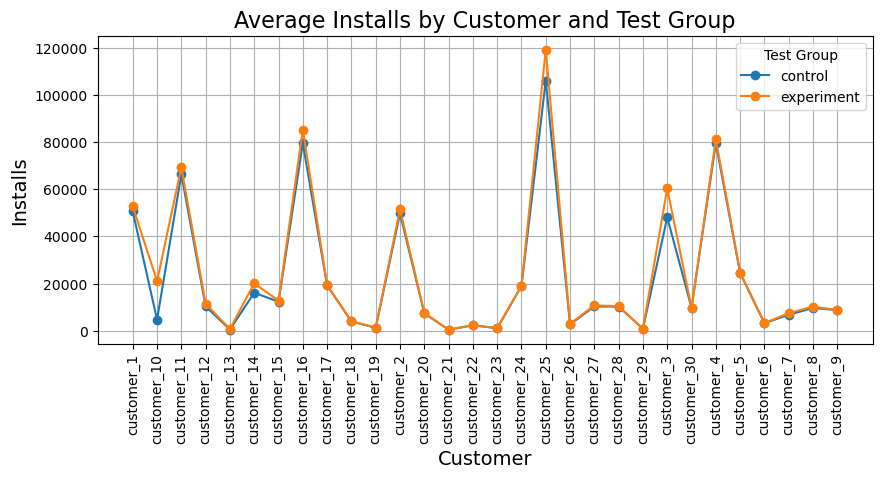

In [128]:
# Visually inspecting installs for control vs experiment for each customer
df1_installs = df1.groupby(['customer','ab_test_group']).agg({'installs':'sum'}).reset_index()
df1_installs = df1_installs.pivot(index='customer', columns='ab_test_group', values='installs')

plt.figure(figsize=(10, 4))
for group in df1_installs.columns:
    plt.plot(df1_installs.index, df1_installs[group], marker='o', label=group)

plt.title("Average Installs by Customer and Test Group", fontsize=16)
plt.xlabel("Customer", fontsize=14)
plt.ylabel("Installs", fontsize=14)
plt.xticks(rotation=90)
plt.legend(title="Test Group")
plt.grid(True)
plt.show()

Visually it looks like the number of installs is similar for most of the clients between control and experiment.

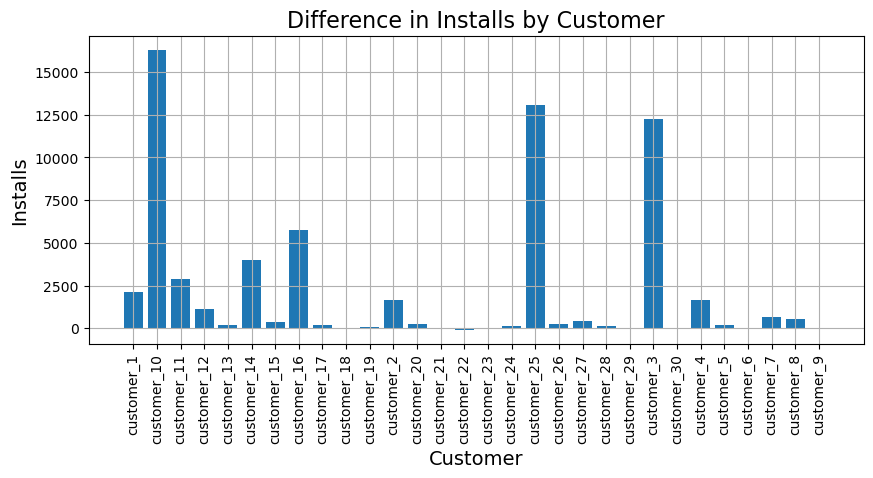

In [129]:
# Calculating the difference in installs
df1_installs['diff'] = df1_installs['experiment'] - df1_installs['control']

plt.figure(figsize=(10, 4))
plt.bar(df1_installs.index,df1_installs['diff'])
plt.title("Difference in Installs by Customer", fontsize=16)
plt.xlabel("Customer", fontsize=14)
plt.ylabel("Installs", fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

<Axes: >

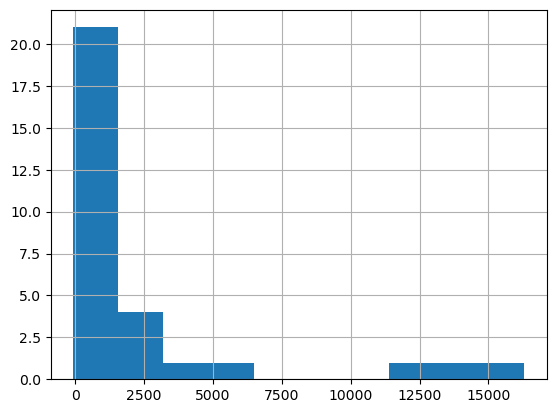

In [58]:
# Checking the distribution of differences
df1_installs['diff'].hist()

As expected, the distribution is not normal - more than half of the customers have their difference closer to 0, while several customers have a big difference. These customers with big difference might be outliers.

In [59]:
# Checking for outliers
median = np.median(df1_installs['diff'])
Q1 = np.quantile(df1_installs['diff'],0.25)
Q3 = np.quantile(df1_installs['diff'],0.75)
IQR = Q3 - Q1
lower = Q1 - IQR * 1.5
upper = Q3 + IQR * 1.5
print(f"Lower bound: {lower}")
print(f"Upper bound: {upper}")

Lower bound: -2342.25
Upper bound: 4055.75


In [60]:
# Removing outliers
no_outliers = df1_installs[(df1_installs['diff'] <= upper) & (df1_installs['diff'] >= lower)]
no_outliers.head()

ab_test_group,control,experiment,diff
customer,,,
customer_1,50570,52675,2105
customer_11,66364,69272,2908
customer_12,10351,11471,1120
customer_13,550,768,218
customer_14,16110,20117,4007


<Axes: >

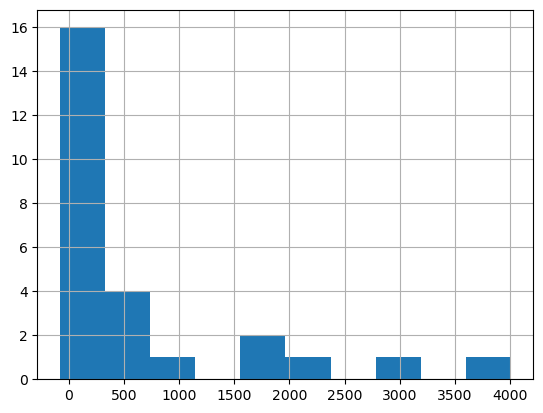

In [61]:
no_outliers['diff'].hist()

Even without outliers the distribution of differences does not look normal.

Differences between experiment and controll installs are not normally distributed. However, since we have 30 clients and each client has 15 days of data, we can try using daily average difference in installs across 15 days for each client (using Central Limit Theorem). 

In [64]:
# Reshaping the data
df1_installs2 = df1.melt(
    id_vars=['date','customer','ab_test_group'],
    value_vars=['installs']
).pivot(index=['date','customer'],
       columns='ab_test_group',
       values='value').reset_index()
df1_installs2.head()

ab_test_group,date,customer,control,experiment
0,2022-09-02,customer_1,3819,4202
1,2022-09-02,customer_10,430,2427
2,2022-09-02,customer_11,4126,4201
3,2022-09-02,customer_12,701,668
4,2022-09-02,customer_13,23,4


<Axes: >

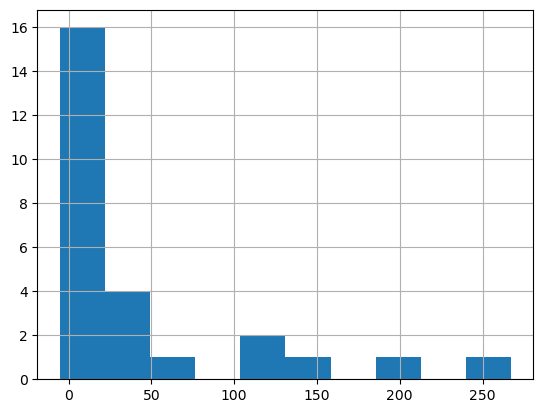

In [65]:
# Calculating avg difference in installs for each customer
df1_installs2['diff'] = df1_installs2['experiment'] - df1_installs2['control']
df1_installs2 = df1_installs2.groupby('customer').agg({'diff':'mean'}).reset_index()

median = np.median(df1_installs2['diff'])
Q1 = np.quantile(df1_installs2['diff'],0.25)
Q3 = np.quantile(df1_installs2['diff'],0.75)
IQR = Q3 - Q1
lower = Q1 - IQR * 1.5
upper = Q3 + IQR * 1.5
no_outliers2 = df1_installs2[(df1_installs2['diff'] <= upper) & (df1_installs2['diff'] >= lower)]
no_outliers2['diff'].hist()

Since differences are not normally distributed we can't run a paired t-test. But we can use a non-parametric Wilcoxon signed rank test.

#### Running a test

In [88]:
# The null hypothesis of a test is that there is no significant difference in installs between control 
# and experiment groups. At p-value of 0.05 we can reject the null hypothesis and conclude that the feature 
# is successful.

import scipy.stats as stats

statistic, p_value = stats.wilcoxon(df1_installs.control, df1_installs.experiment)

print("Statistic:", statistic)
print("P-value:", p_value)

Statistic: 21.0
P-value: 8.326023817062378e-07


P-value is lower than a threshold of 0.05. We can reject the null hypothesis - it is unlikely that we would have observed this result if the new feature did not increase the number of installs.

#### Checking view-through installs

In [91]:
df2 = pd.read_csv('table2.csv', parse_dates=['date'])
df2.head()

,date,customer,ab_test_group,is_viewthrough_install,installs
0,2022-09-02,customer_1,control,False,3634.0
1,2022-09-02,customer_1,control,True,185.0
2,2022-09-02,customer_1,experiment,False,3266.0
3,2022-09-02,customer_1,experiment,True,936.0
4,2022-09-02,customer_2,control,False,2860.0


In [92]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1786 non-null   datetime64[ns]
 1   customer                1786 non-null   object        
 2   ab_test_group           1786 non-null   object        
 3   is_viewthrough_install  1786 non-null   bool          
 4   installs                1786 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 57.7+ KB


In [94]:
# Selecting only view-through installs
view_through_inst = df2[df2['is_viewthrough_install']==True].groupby(['customer','ab_test_group']
).agg({'installs':'sum'}
     ).reset_index().pivot(index='customer',
                           columns='ab_test_group',
                           values='installs').reset_index()

view_through_inst.head()

ab_test_group,customer,control,experiment
0,customer_1,2761.0,11411.0
1,customer_10,1631.0,19917.0
2,customer_11,28228.0,36380.0
3,customer_12,759.0,3124.0
4,customer_13,109.0,485.0


In [95]:
# Calculating the difference in view-through installs
view_through_inst['diff'] = view_through_inst['experiment'] - view_through_inst['control']
view_through_summarised = view_through_inst.groupby('customer').agg({'diff':'mean'}).reset_index()
view_through_summarised.head()

ab_test_group,customer,diff
0,customer_1,8650.0
1,customer_10,18286.0
2,customer_11,8152.0
3,customer_12,2365.0
4,customer_13,376.0


In [122]:
# Adding the data whether customer is sensitive to view-through installs
VT_sensitivity = df1.groupby('customer').agg({'customer_sensitive_to_VT':'max'}).reset_index()
merged = view_through_summarised.merge(VT_sensitivity,on='customer')
merged.head()

,customer,diff,customer_sensitive_to_VT
0,customer_1,8650.0,False
1,customer_10,18286.0,False
2,customer_11,8152.0,False
3,customer_12,2365.0,False
4,customer_13,376.0,False


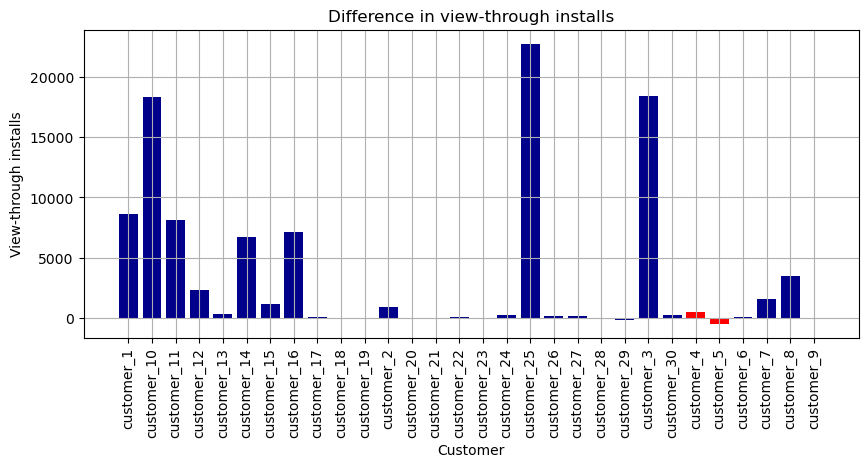

In [140]:
# Overlaying the increase in view-through installs with information whether customer is sensitive to VT
color_mapping = {True: 'red', False: 'darkblue'}
colors = merged['customer_sensitive_to_VT'].map(color_mapping)
plt.figure(figsize=(10,4))
plt.bar(merged['customer'],merged['diff'],color=colors)
plt.xticks(rotation=90)
plt.title('Difference in view-through installs')
plt.xlabel('Customer')
plt.ylabel('View-through installs')
plt.grid(True)
plt.show()

Customers which saw significant increase in view-through installs are not sensitive to view-through installs, so there is no significant risk with rolling out the feature.